In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Tieuluan2024'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Tieuluan2024


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



In [3]:
df = pd.read_csv('imputed_taiwan_saits_new.csv')
df['time'] =pd.to_datetime(df.time,format="%Y-%m-%d %H:%M:%S")
df.head()

,Unnamed: 0,station,time,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,...,RAINFALL,RAIN_COND,RH,SO2,THC,UVB,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,0,Banqiao,2015-01-01 00:00:00,16.000000,2.1,0.79,0.14,1.200000,16.0,17.000000,...,-1.0,-1.0,57.0,12.0,2.2,-6.118071e-08,69.0,69.0,4.7,4.2
1,1,Banqiao,2015-01-01 01:00:00,16.000000,2.1,0.80,0.15,1.300000,16.0,17.000000,...,-1.0,-1.0,57.0,11.0,2.2,-6.118071e-08,67.0,65.0,4.0,4.0
2,2,Banqiao,2015-01-01 02:00:00,16.000000,2.1,0.71,0.13,1.000000,13.0,14.000000,...,-1.0,-1.0,57.0,8.0,2.2,-6.118071e-08,63.0,53.0,3.7,3.5
3,3,Banqiao,2015-01-01 03:00:00,15.000001,2.0,0.66,0.12,0.800001,11.0,11.999999,...,-1.0,-1.0,58.0,6.5,2.2,-6.118071e-08,63.0,63.0,4.1,3.3
4,4,Banqiao,2015-01-01 04:00:00,15.000001,2.0,0.53,0.11,0.600000,10.0,11.000000,...,-1.0,-1.0,58.0,5.5,2.1,-6.118071e-08,69.0,67.0,3.0,3.1


In [4]:
# Lấy giá trị từ DataFrame

#
data = df
data.index = data['time']
data =  data.drop('station',axis=1)
data=  data.drop('time',axis=1)
data =  data.drop('Unnamed: 0',axis=1)


values = data.values
values_non= values

In [5]:
num_dimensions = df.shape[1]
print(f"Số chiều của dữ liệu: {num_dimensions}")

# Độ dày của dữ liệu (số lượng mẫu)
data_density = len(data)
print(f"Độ dày của dữ liệu: {data_density}")

# Tính khối lượng dữ liệu (dung lượng bộ nhớ)
data_size_bytes = data.memory_usage(deep=True).sum()
data_size_mb = data_size_bytes / (1024 * 1024)
print(f"Khối lượng dữ liệu: {data_size_mb:.2f} MB")

# Tính cấu trúc của dữ liệu (kiểm tra các cột có dữ liệu không bị thiếu)
missing_values = data.isnull().sum().sum()
if missing_values > 0:
    print("Dữ liệu không có cấu trúc đầy đủ")
else:
    print("Dữ liệu có cấu trúc đầy đủ")

# Sự tương quan và phụ thuộc (correlation matrix)
correlation_matrix = data.corr()
print("Ma trận tương quan:")
print(correlation_matrix)

# Độ nhiễu của dữ liệu (tính toán số lượng ngoại lệ)
from scipy.stats import zscore
outliers_count = (np.abs(zscore(data)) > 3).sum()  # Số lượng ngoại lệ khi z-score lớn hơn 3
print(f"Số lượng ngoại lệ trong dữ liệu: {outliers_count}")
# Sử dụng Interquartile Range (IQR) để phát hiện ngoại lệ
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum().sum()
print(f"Số lượng ngoại lệ (theo IQR): {outliers}")

Số chiều của dữ liệu: 24
Độ dày của dữ liệu: 218640
Khối lượng dữ liệu: 36.70 MB
Dữ liệu có cấu trúc đầy đủ
Ma trận tương quan:
            AMB_TEMP       CH4        CO      NMHC        NO       NO2  \
AMB_TEMP    1.000000 -0.164470 -0.032349  0.071101  0.019824  0.011684   
CH4        -0.164470  1.000000  0.449621  0.540601  0.441177  0.427758   
CO         -0.032349  0.449621  1.000000  0.867794  0.756823  0.701464   
NMHC        0.071101  0.540601  0.867794  1.000000  0.819065  0.775494   
NO          0.019824  0.441177  0.756823  0.819065  1.000000  0.587215   
NO2         0.011684  0.427758  0.701464  0.775494  0.587215  1.000000   
NOx         0.020352  0.486576  0.809824  0.893680  0.929775  0.842323   
O3         -0.038421 -0.311981 -0.362054 -0.470909 -0.415302 -0.459458   
PH_RAIN    -0.126337 -0.083196 -0.094113 -0.141470 -0.079511 -0.115389   
PM10       -0.077951  0.295023  0.292238  0.307745  0.200071  0.382677   
PM2.5      -0.088219  0.210296  0.211033  0.221146  0.0538

Số lượng ngoại lệ trong dữ liệu: AMB_TEMP       494
CH4           4010
CO            3866
NMHC          4845
NO            6018
NO2           2190
NOx           5360
O3            1459
PH_RAIN       8023
PM10          3466
PM2.5         3508
RAINFALL       920
RAIN_COND     1048
RH            1079
SO2            724
THC           4166
UVB           3538
WD_HR            0
WIND_DIREC       0
WIND_SPEED    3888
WS_HR         4004
dtype: int64


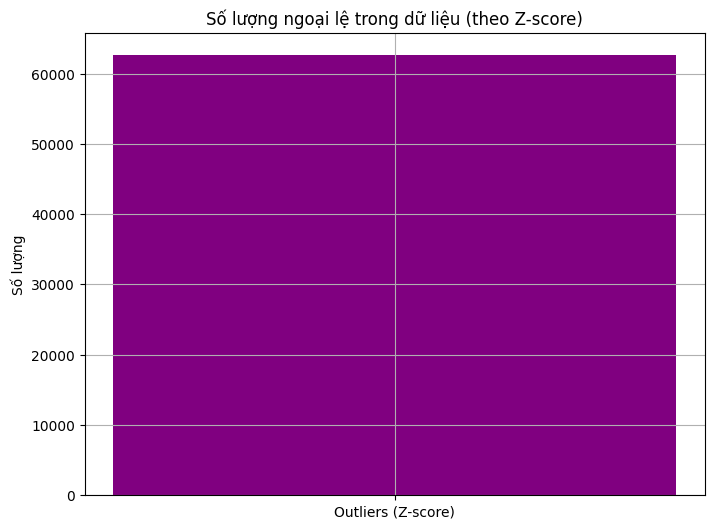

In [6]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
outliers_count = (np.abs(zscore(data)) > 3).sum()  # Số lượng ngoại lệ khi z-score lớn hơn 3
print(f"Số lượng ngoại lệ trong dữ liệu: {outliers_count}")

total_outliers = outliers_count.sum() # Calculate the total number of outliers

plt.figure(figsize=(8, 6))
plt.bar(['Outliers (Z-score)'], [total_outliers], color='purple') # Pass the total number of outliers
plt.title('Số lượng ngoại lệ trong dữ liệu (theo Z-score)')
plt.ylabel('Số lượng')
plt.grid(True)
plt.show()

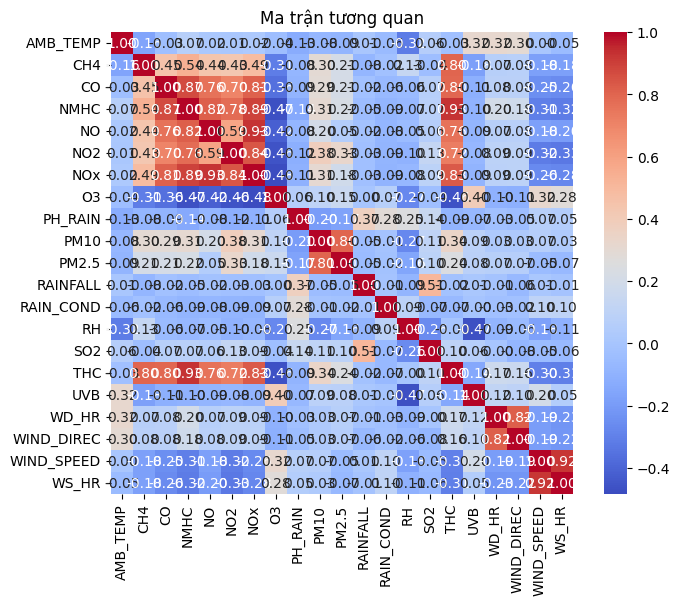

In [7]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Ma trận tương quan')
plt.show()



In [8]:

# Chuẩn hóa dữ liệu vào khoảng [0, 1]
scalers = {}
for column in data.columns:
    scaler = MinMaxScaler()
    data[column] = scaler.fit_transform(data[[column]])
    scalers[column] = scaler


In [9]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Đặt độ dài chuỗi
SEQ_LENGTH = 50

# Tạo dữ liệu đầu vào và đầu ra cho LSTM
X, y = create_sequences(data, SEQ_LENGTH)


In [10]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [11]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=y.shape[1]))

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
#


In [12]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
4372/4372 [==============================] - 261s 59ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 2/20
4372/4372 [==============================] - 255s 58ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 4/20
4372/4372 [==============================] - 256s 59ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 5/20
4372/4372 [==============================] - 262s 60ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 6/20
4372/4372 [==============================] - 255s 58ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 7/20
4372/4372 [==============================] - 255s 58ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 8/20
4372/4372 [==============================] - 254s 58ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 9/20
4372/4372 [==============================] - 251s 57ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 10/20
4372/4372 [==============================] - 249s 57ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 11/20
4372/4372 [==============================]

In [13]:
print('trainX shape == {}.'.format(X_train.shape))
print('trainX shape == {}.'.format(X_test.shape))
trainX_rf = X_train[:, -1, :]
testX_rf = X_test[:, -1, :]

print('trainX_rf shape == {}.'.format(trainX_rf.shape))
print('trainX_rf shape == {}.'.format(testX_rf.shape))


# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
#Xtrain_rf,ytrain_rf = df.iloc[:-n_test]  # 80% dữ liệu đầu để huấn luyện
#test_data = df.iloc[-n_test:]   # 20% dữ liệu cuối để kiểm tra

trainX shape == (174872, 50, 21).
trainX shape == (43718, 50, 21).
trainX_rf shape == (174872, 21).
trainX_rf shape == (43718, 21).


In [14]:
from sklearn.ensemble import RandomForestRegressor
rfe =RandomForestRegressor(n_estimators=100, random_state=1)
history2 = rfe.fit(trainX_rf, y_train)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error


y_pred = model.predict(X_test)
y_pred2 = rfe.predict(testX_rf)
# Đảo ngược chuẩn hóa cho y_test và y_pred và y_pred2
for i, column in enumerate(data.columns):
    y_test[:, i] = scalers[column].inverse_transform(y_test[:, i].reshape(-1, 1)).reshape(-1)
    y_pred[:, i] = scalers[column].inverse_transform(y_pred[:, i].reshape(-1, 1)).reshape(-1)
    y_pred2[:, i] = scalers[column].inverse_transform(y_pred2[:, i].reshape(-1, 1)).reshape(-1)

R2_lstm = r2_score(y_test, y_pred)
RMSE_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
mae_lstm = np.mean(np.abs(y_pred - y_test))

R2_rf = r2_score(y_test, y_pred2)
RMSE_rf = np.sqrt(mean_squared_error(y_test, y_pred2))
mae_rf = np.mean(np.abs(y_pred2 - y_test))

print("Mean Absolute Error (MAE):", mae_lstm)
print("Mean Squared Error (RMSE):", RMSE_lstm)
print("R2 Score:", R2_lstm)

print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (RMSE):", RMSE_rf)
print("R2 Score:", R2_rf)


1367/1367 [==============================] - 28s 19ms/step
Mean Absolute Error (MAE): 4.085215773513573
Mean Squared Error (RMSE): 15.201998666205546
R2 Score: 0.6909931218611679
Mean Absolute Error (MAE): 5.198186108469801
Mean Squared Error (RMSE): 16.48981769734492
R2 Score: 0.6208389271357345


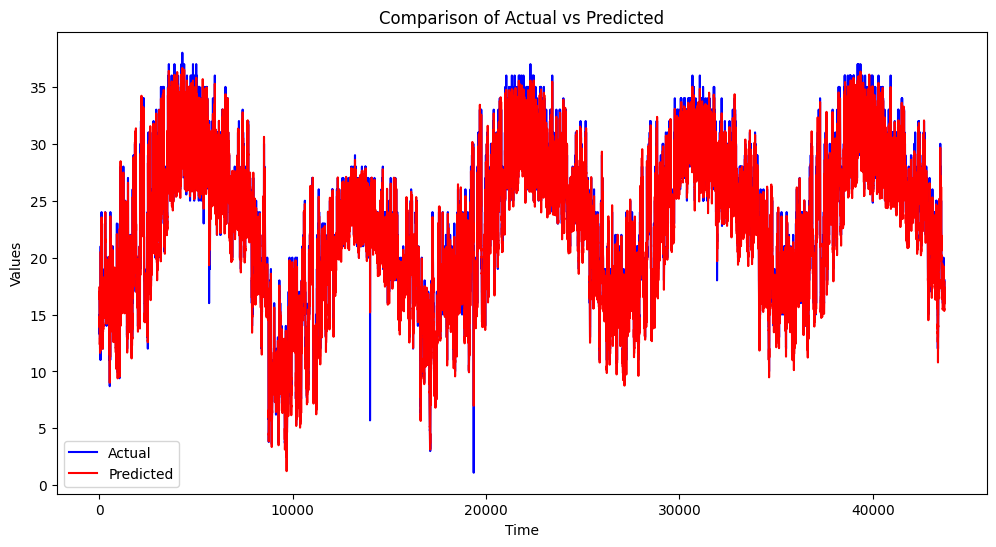

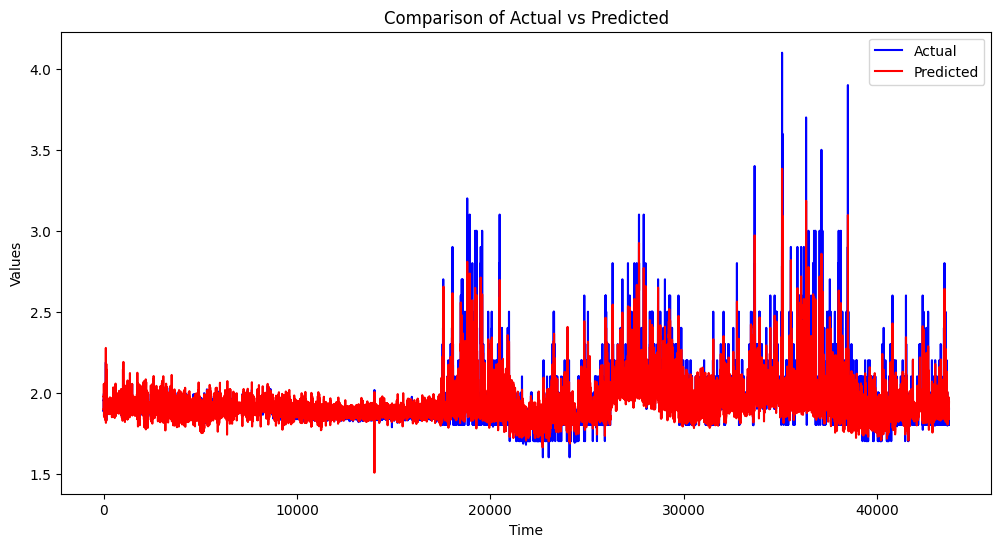

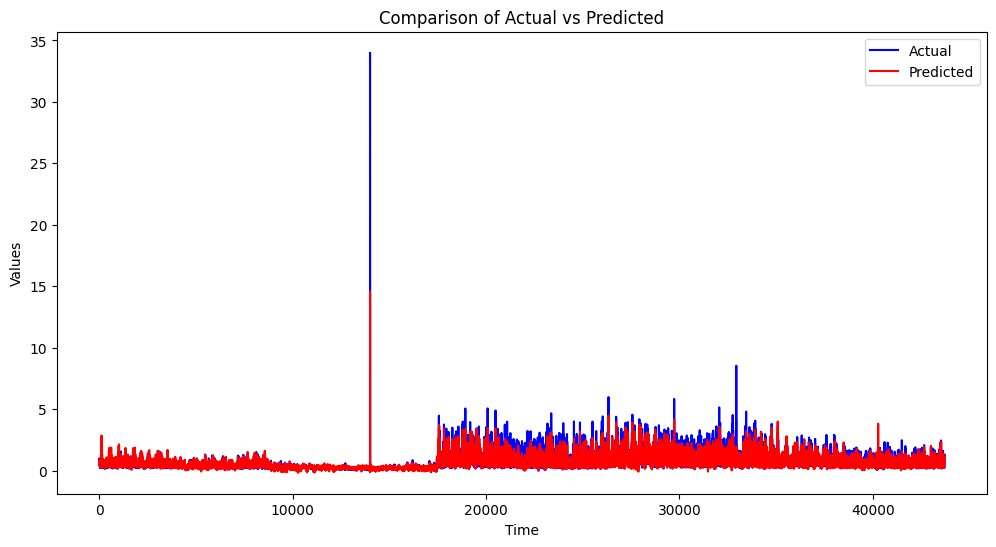

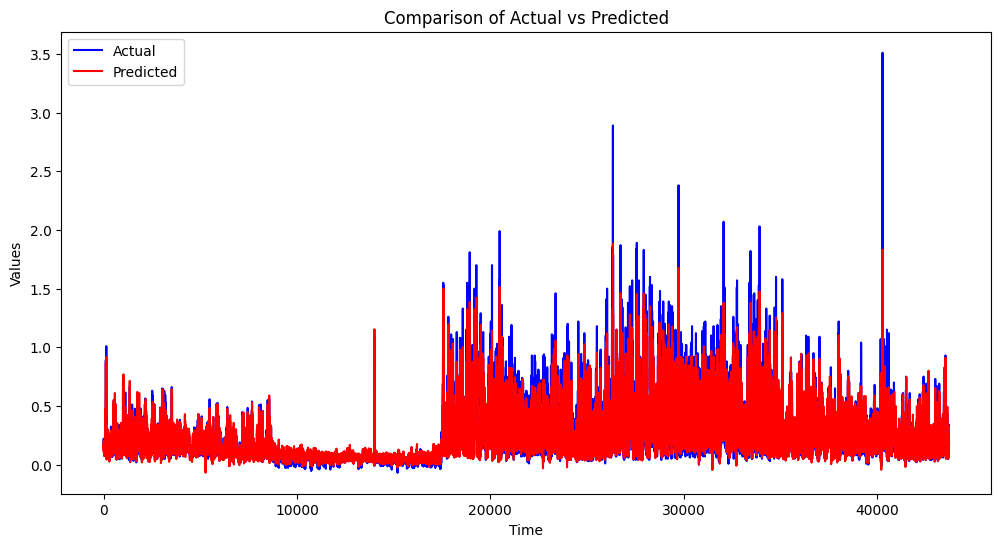

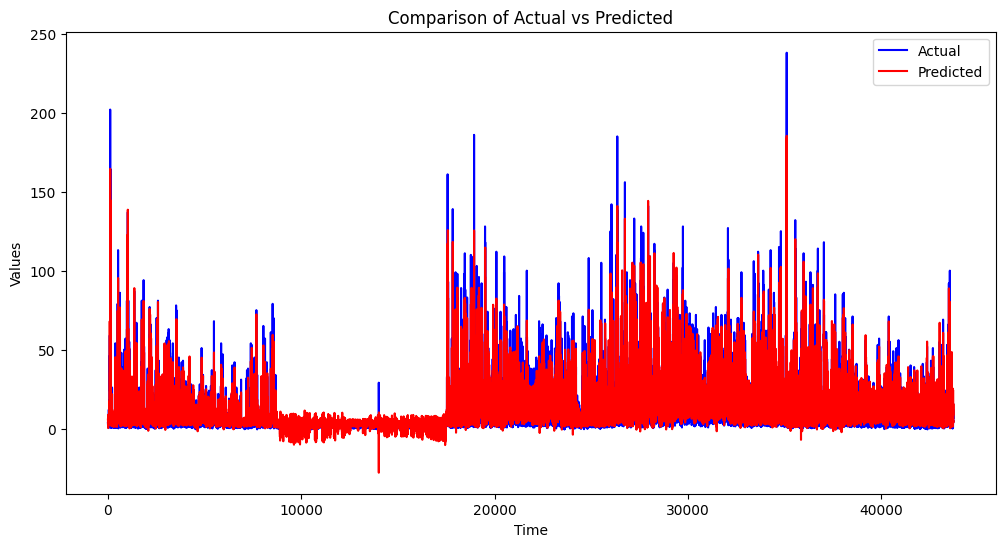

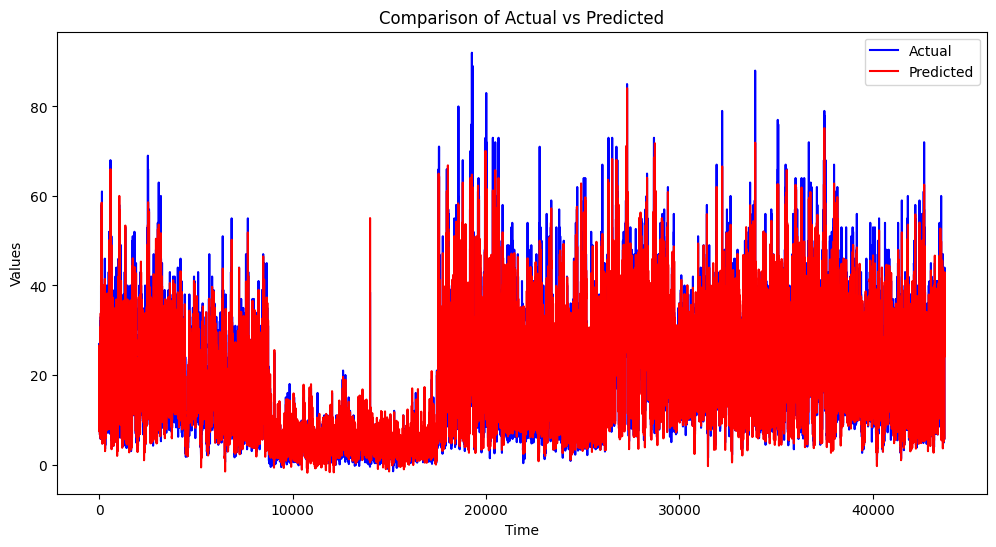

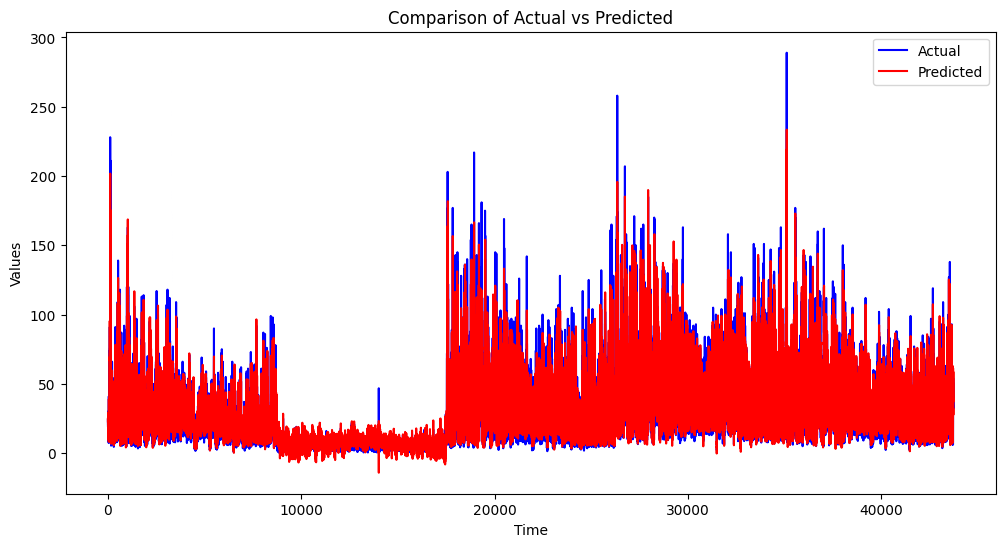

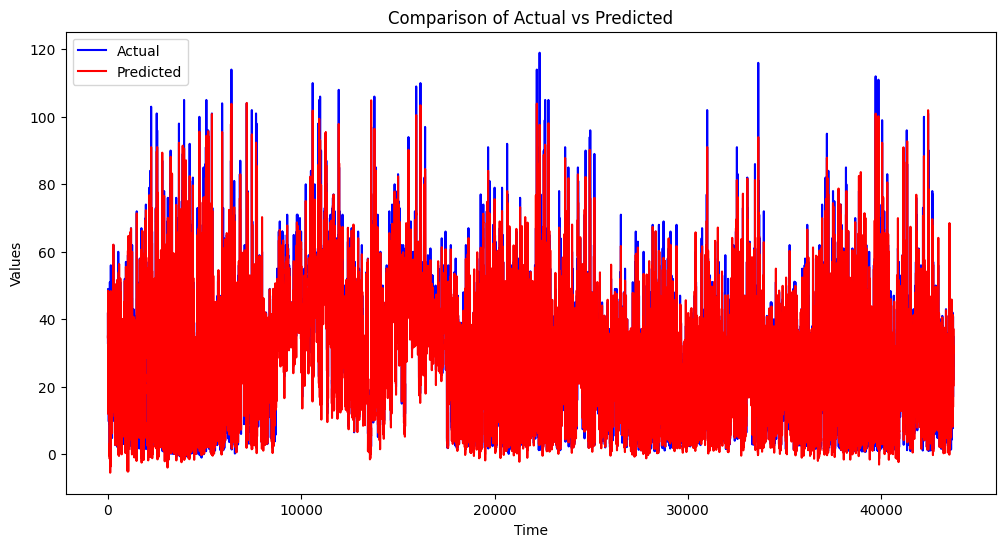

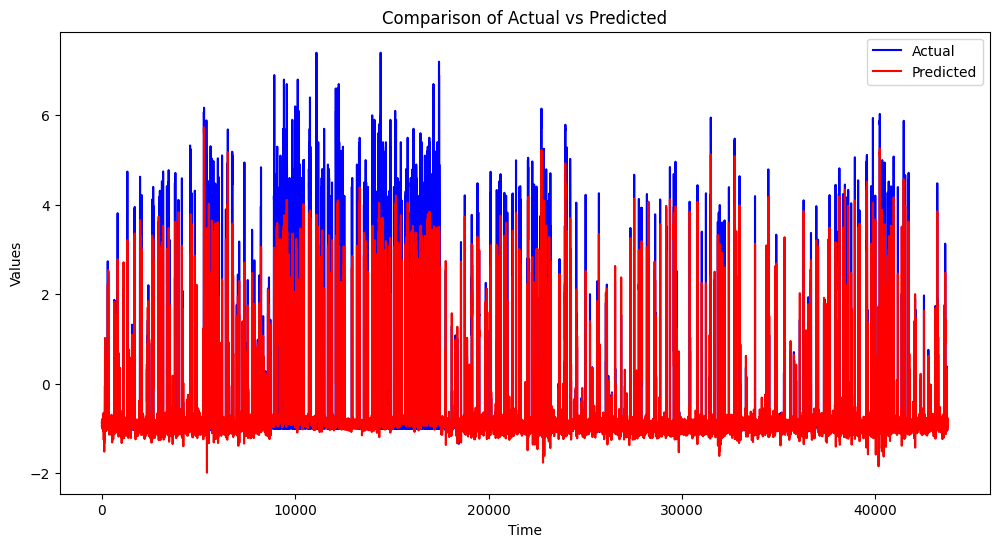

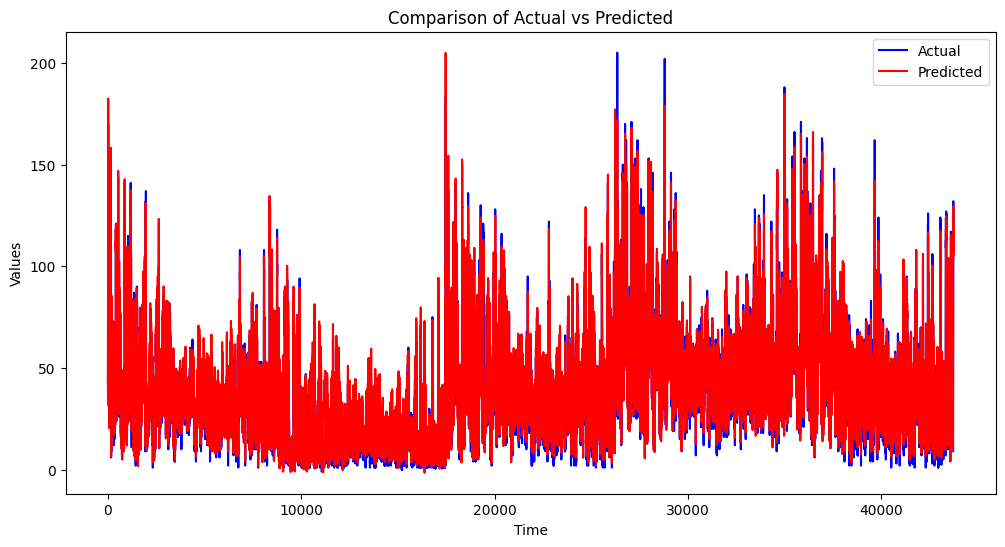

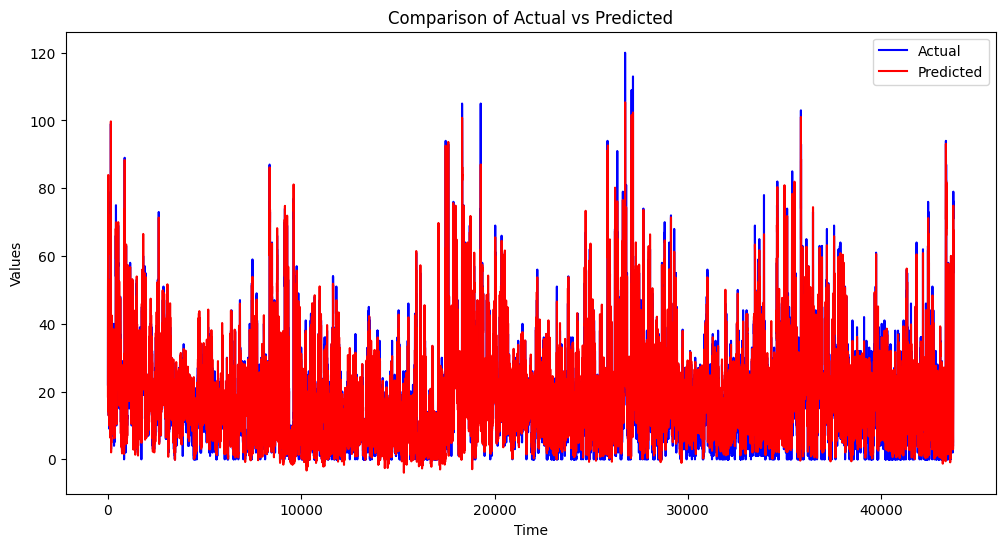

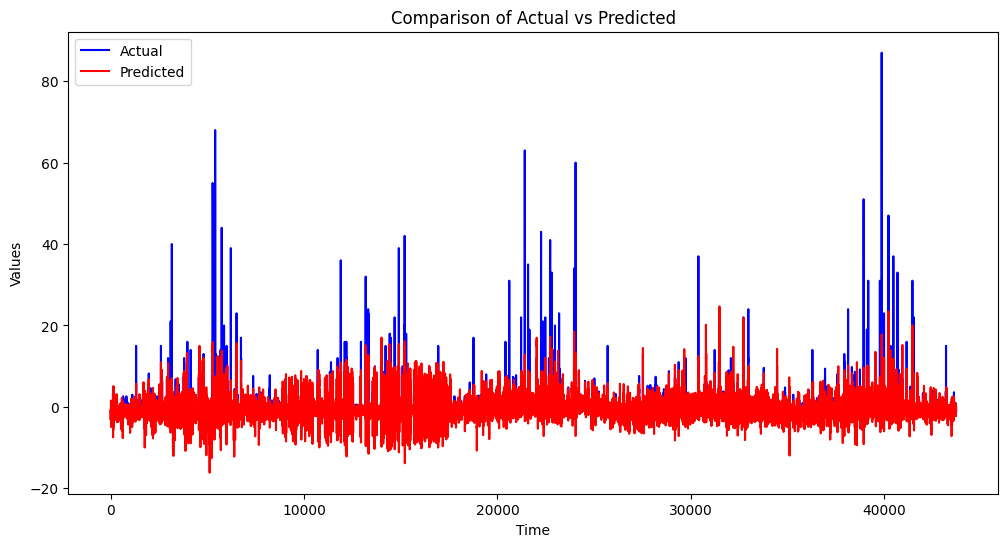

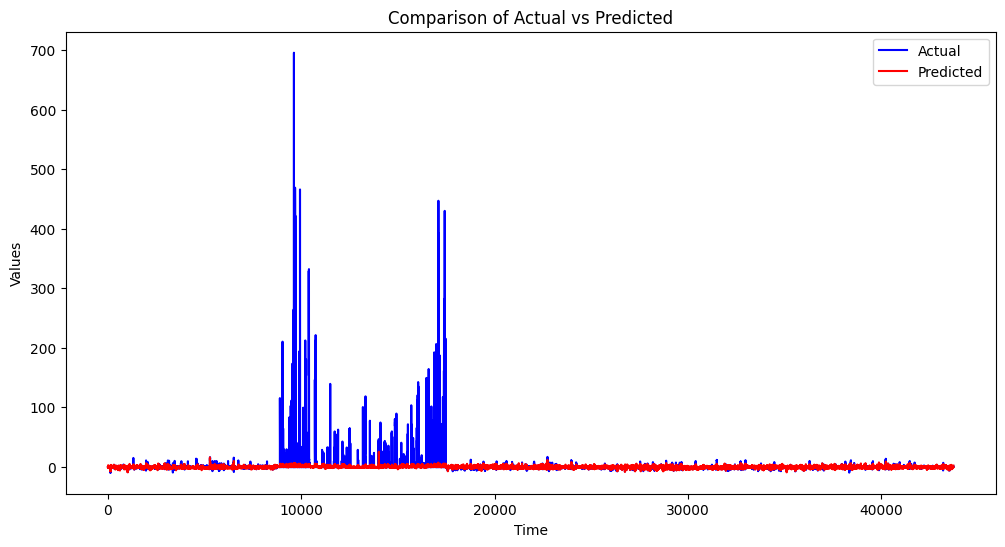

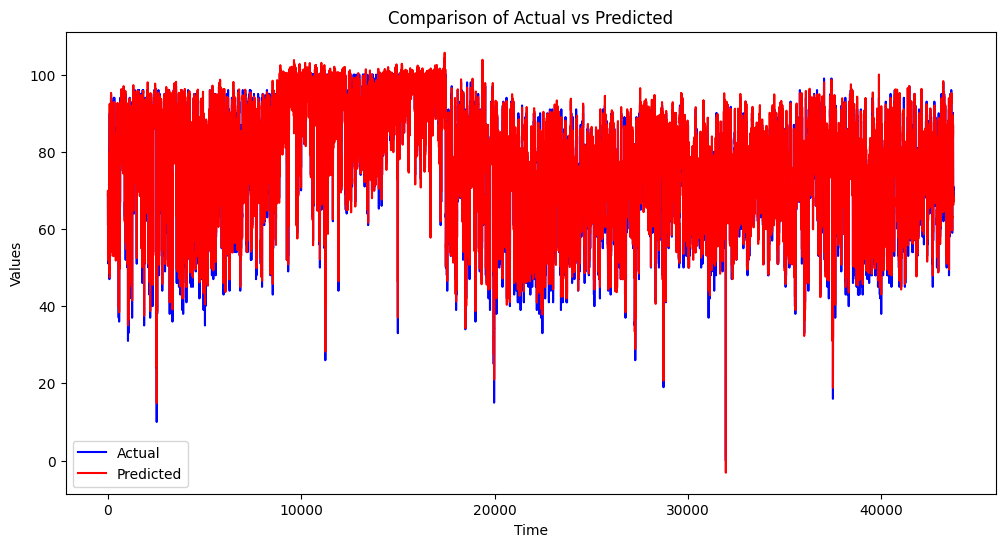

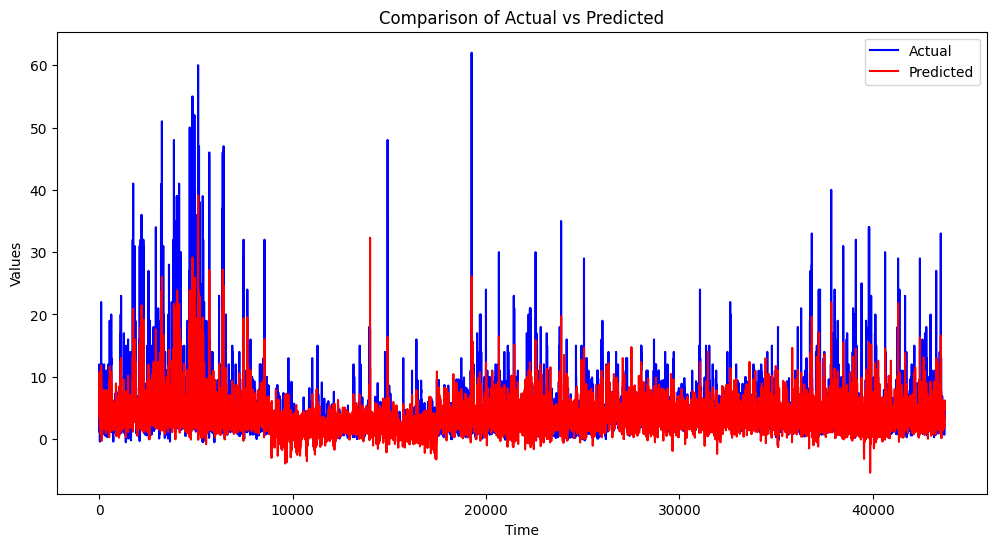

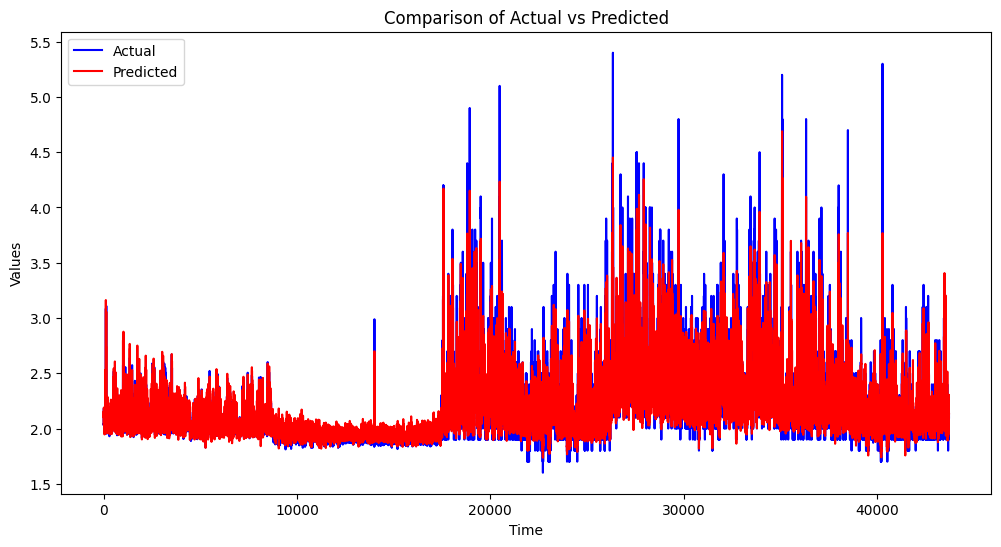

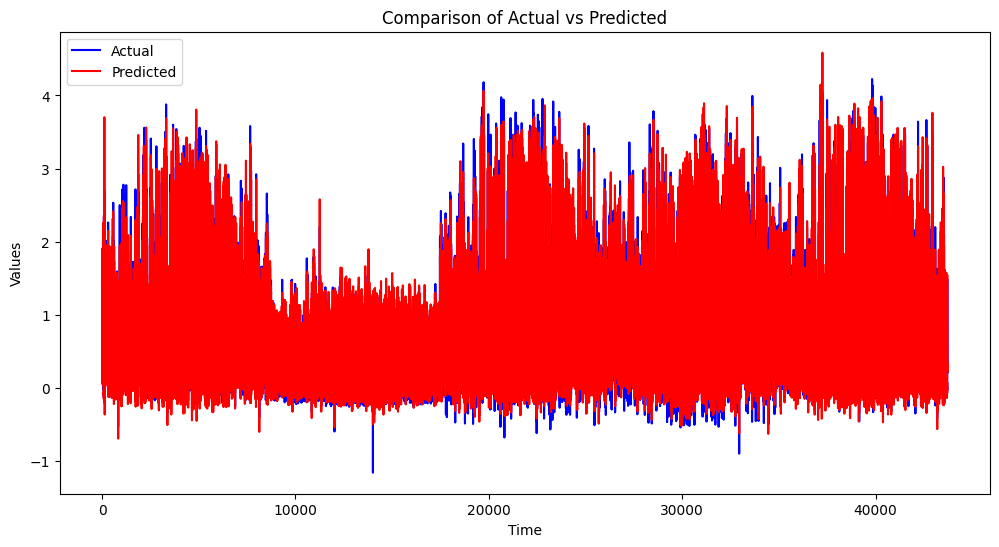

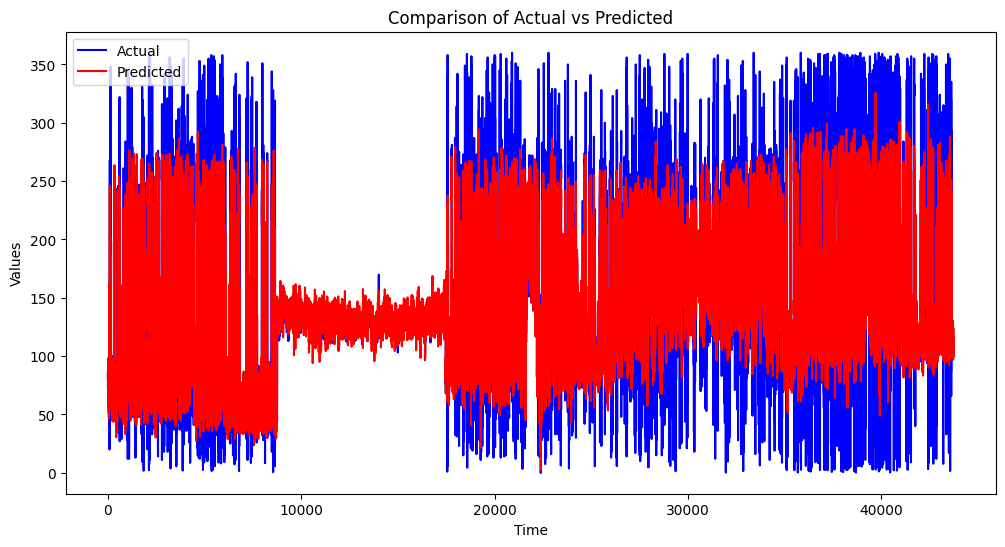

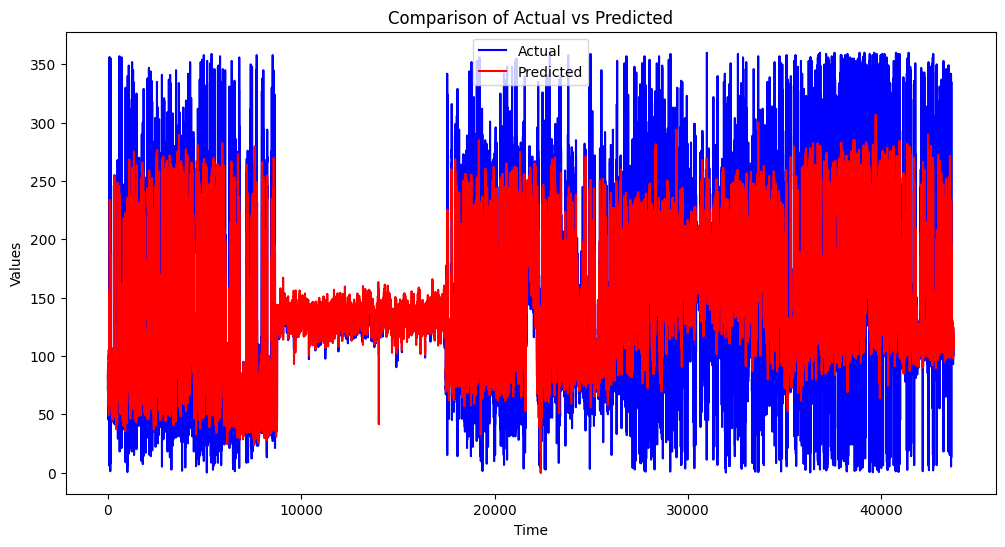

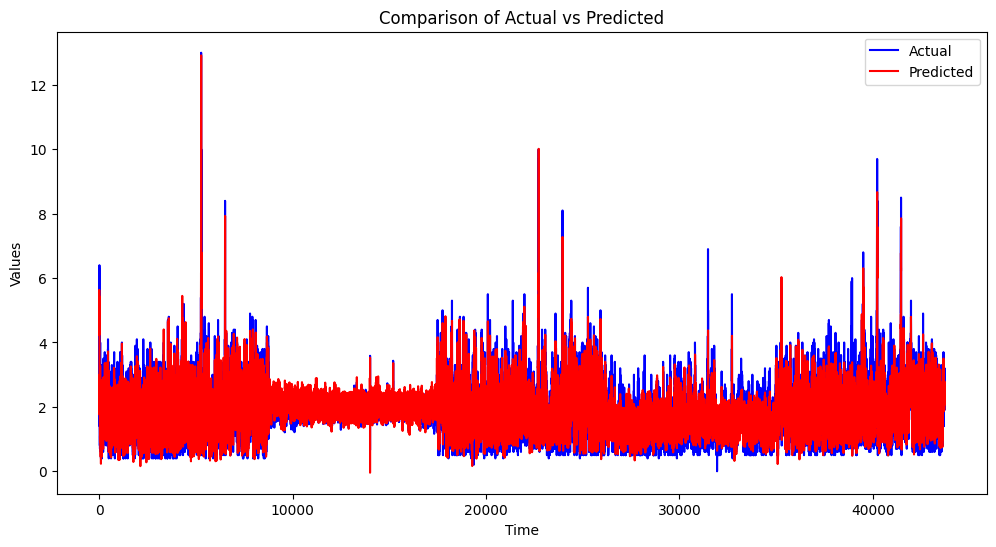

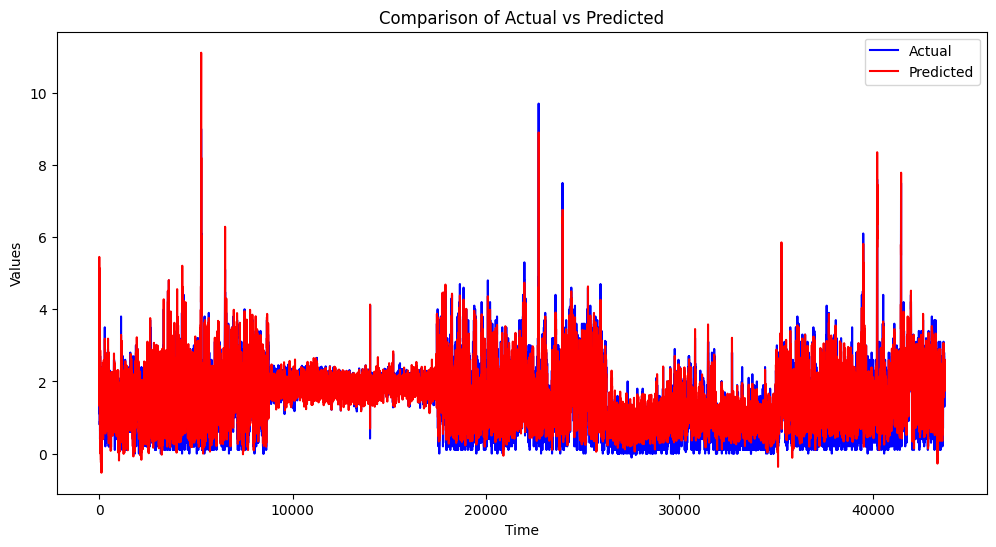

In [16]:
# Đánh giá mô hình trên tập kiểm tra
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error

#loss = model.evaluate(X_test, y_test)
#print(f'Mean Squared Error on Test Data: {loss}')

# Tính toán sai số trung bình tuyệt đối và sai số bình phương trung bình
# Dự đoán trên tập kiểm tra
#y_pred = model.predict(X_test)

#mae = np.mean(np.abs(y_pred - y_test))
#mse = np.mean(np.square(y_pred - y_test))

#print("Mean Absolute Error (MAE):", mae)
#print("Mean Squared Error (MSE):", mse)

# Đảo ngược chuẩn hóa cho y_test và y_pred
#for i, column in enumerate(data.columns):
#    y_test[:, i] = scalers[column].inverse_transform(y_test[:, i].reshape(-1, 1)).reshape(-1)
#    y_pred[:, i] = scalers[column].inverse_transform(y_pred[:, i].reshape(-1, 1)).reshape(-1)
#import matplotlib.pyplot as plt
for i in range(y_test.shape[1]):
  plt.figure(figsize=(12, 6))
  plt.plot(y_test[:, i], color='blue', label='Actual')
  plt.plot(y_pred[:, i], color='red', label='Predicted')
  plt.title('Comparison of Actual vs Predicted')
  plt.xlabel('Time')
  plt.ylabel('Values')
  plt.legend()
  plt.show()


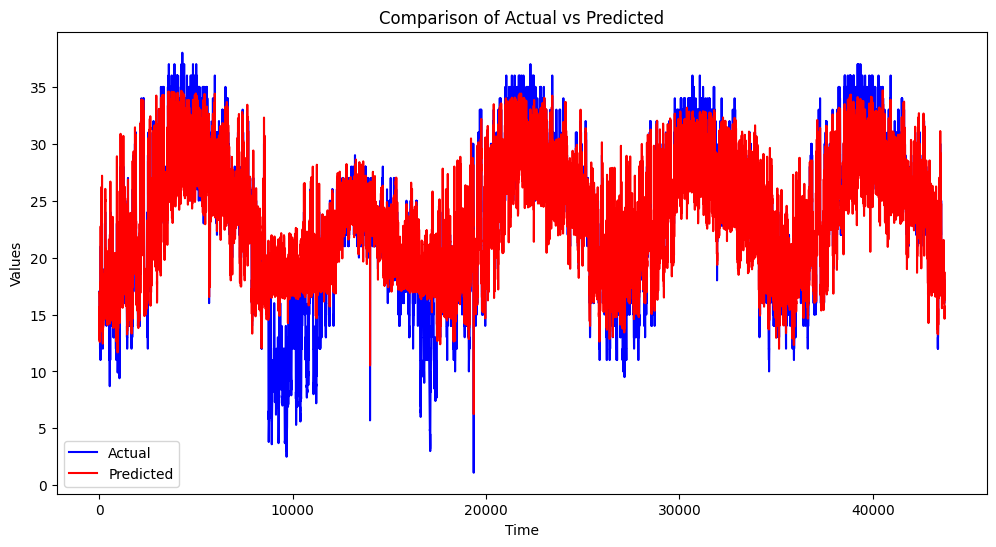

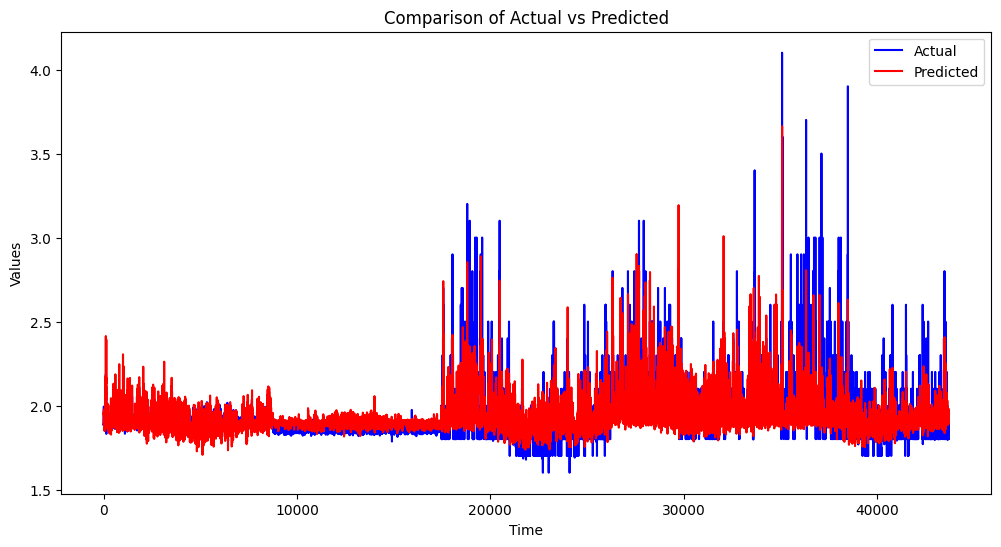

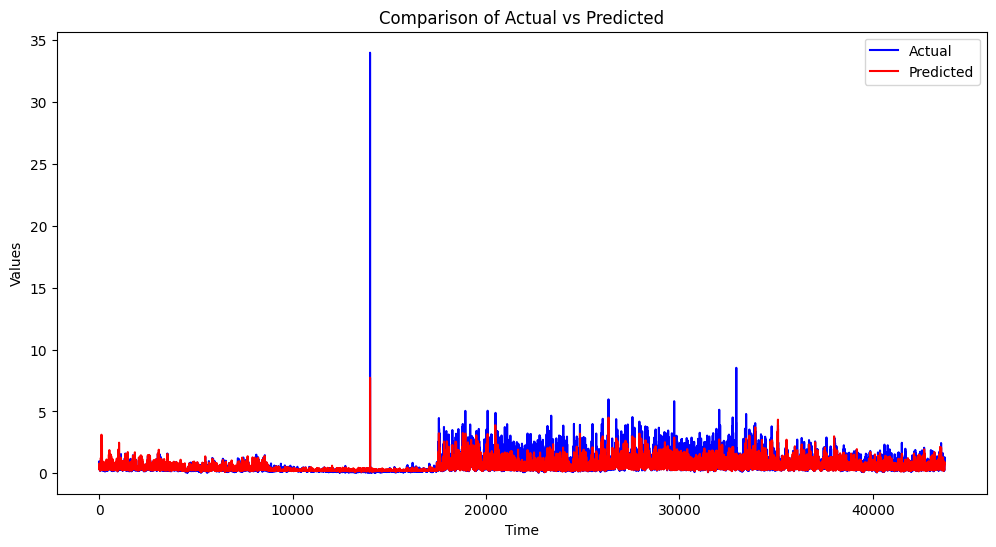

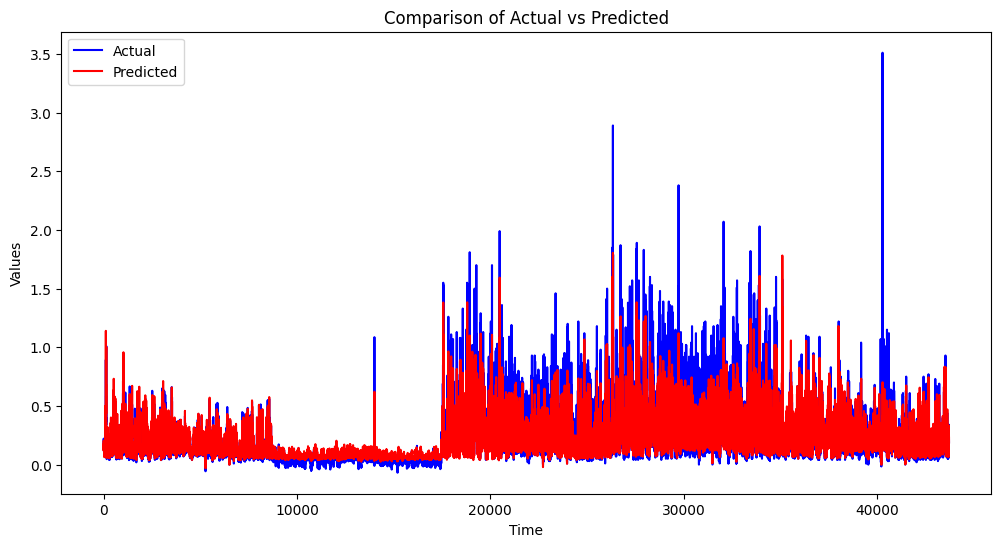

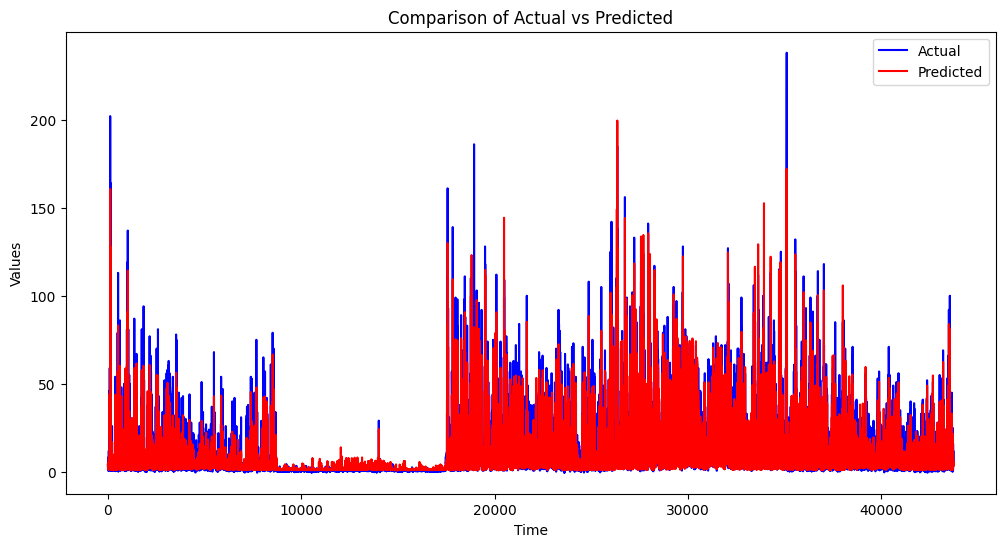

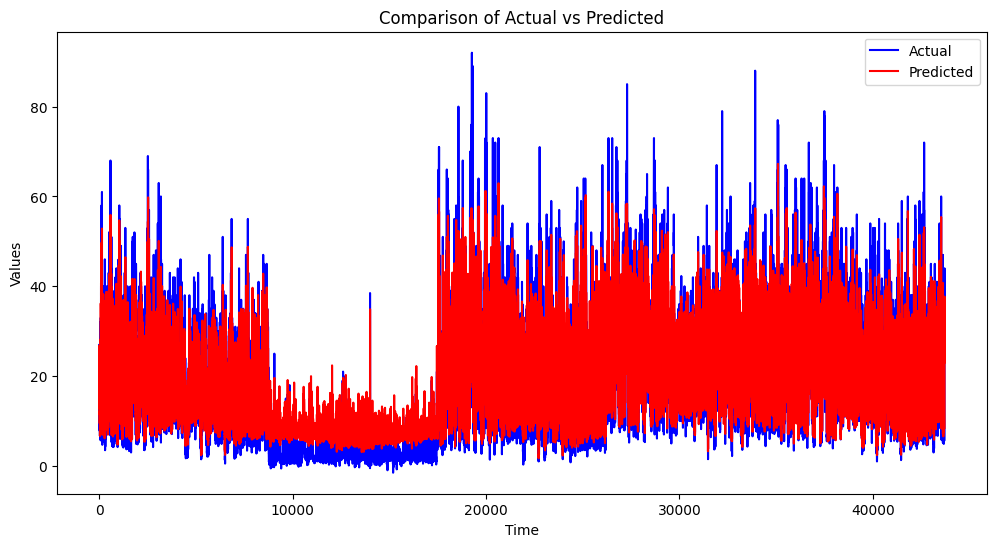

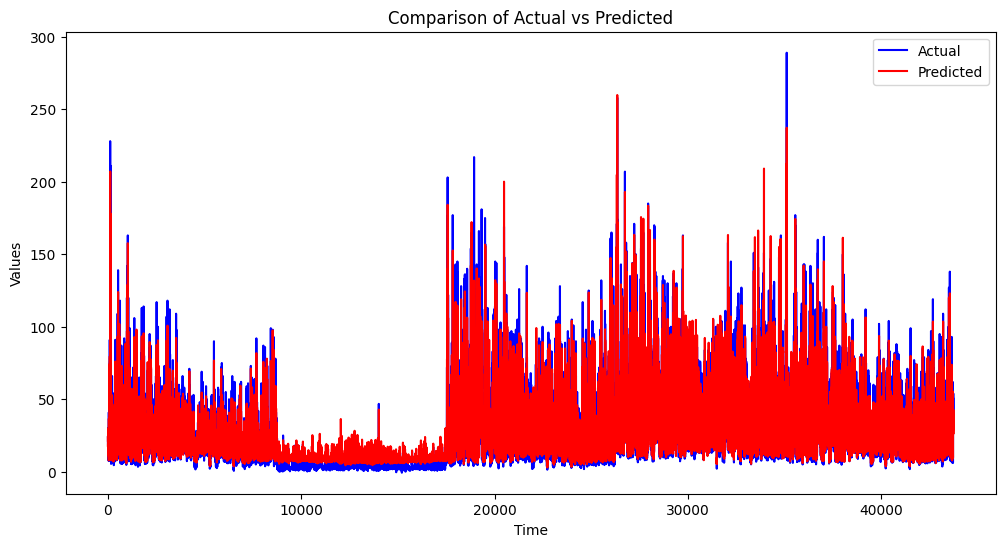

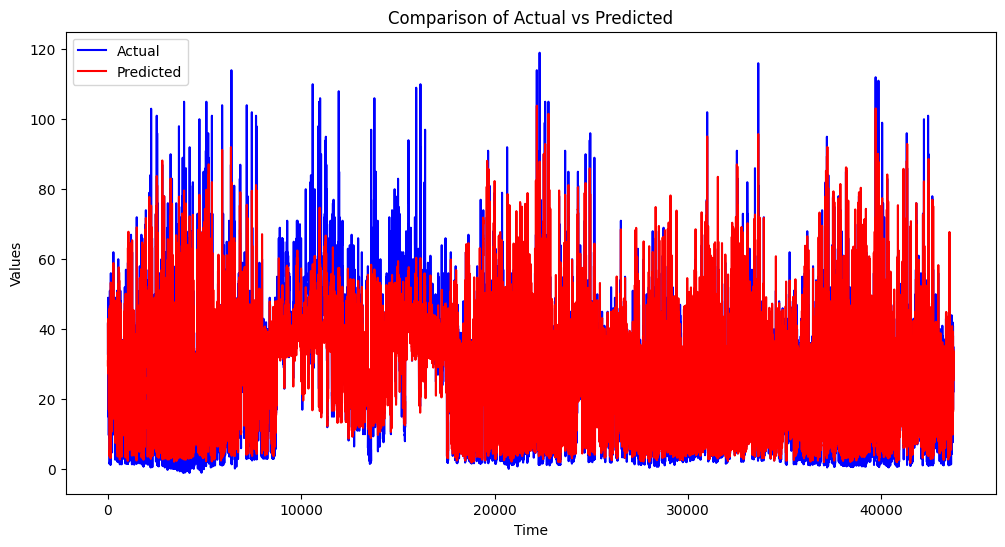

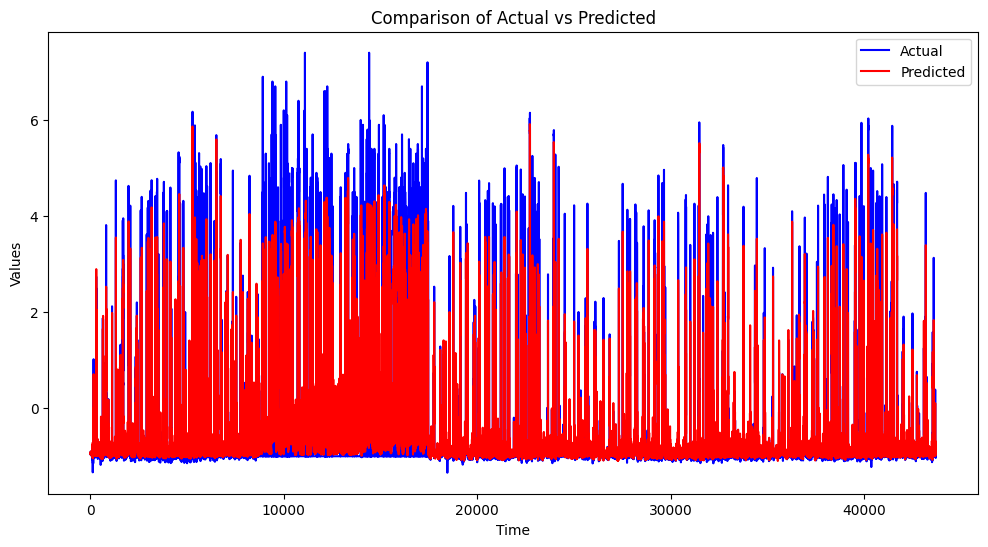

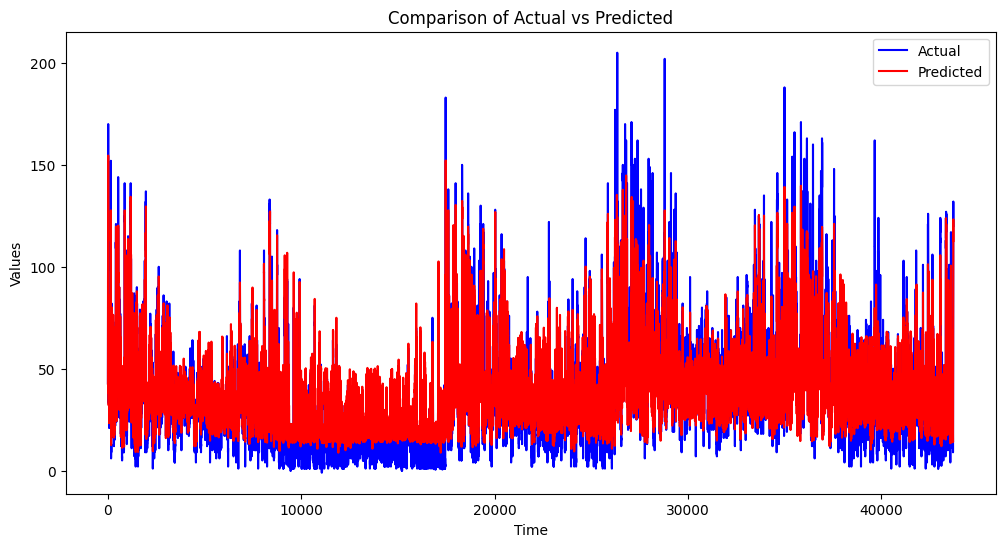

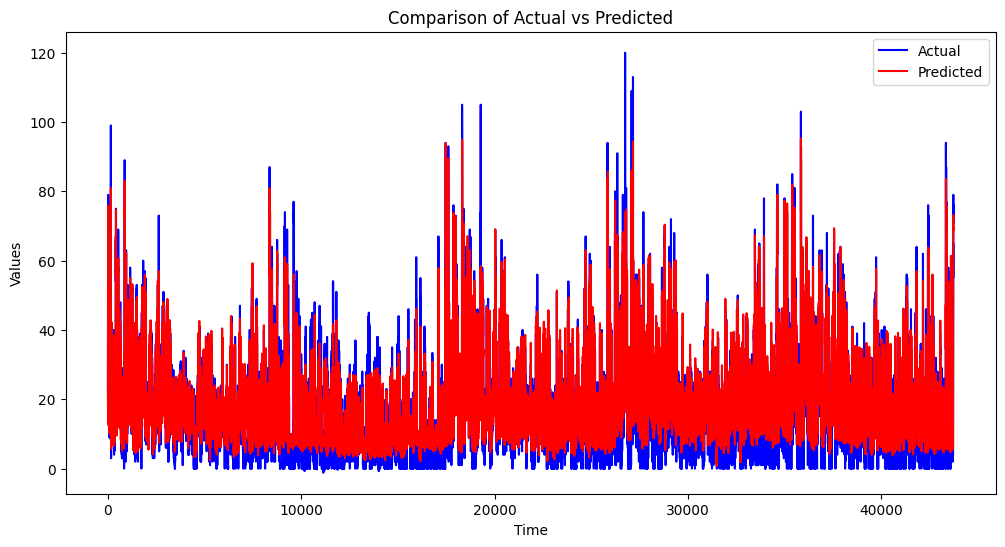

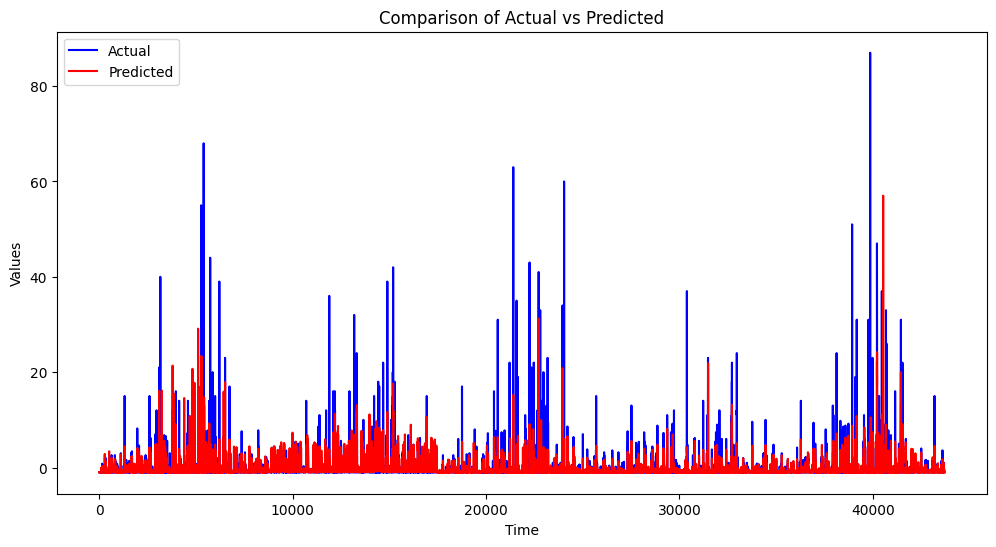

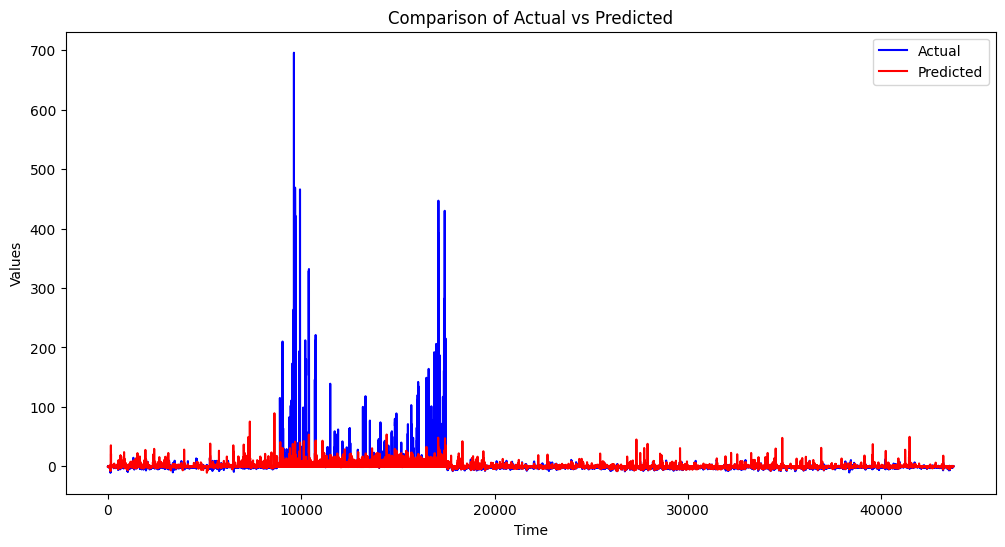

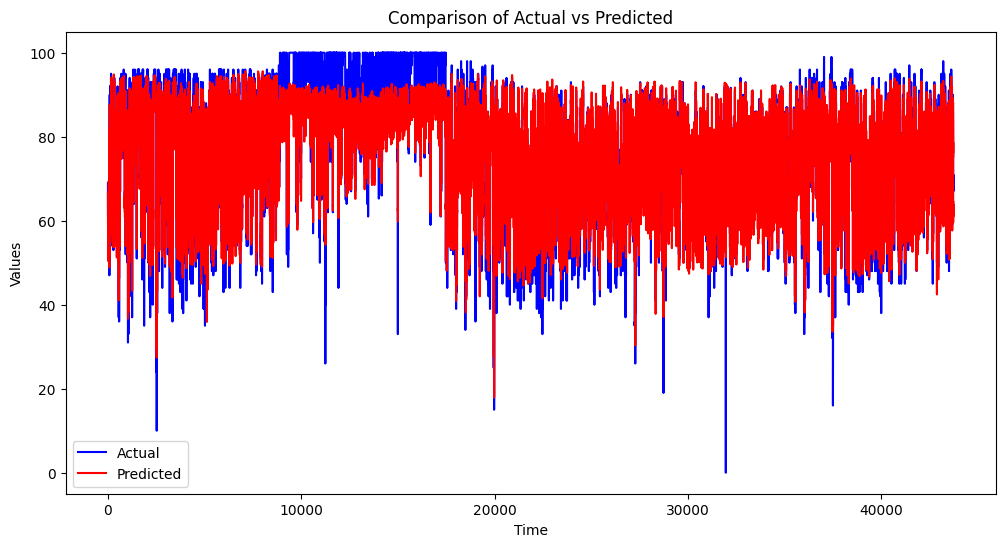

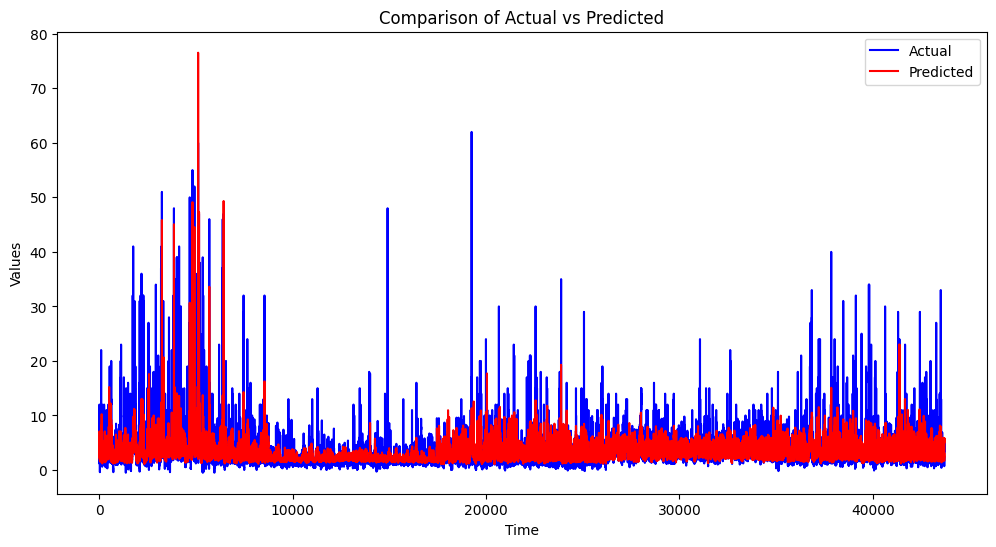

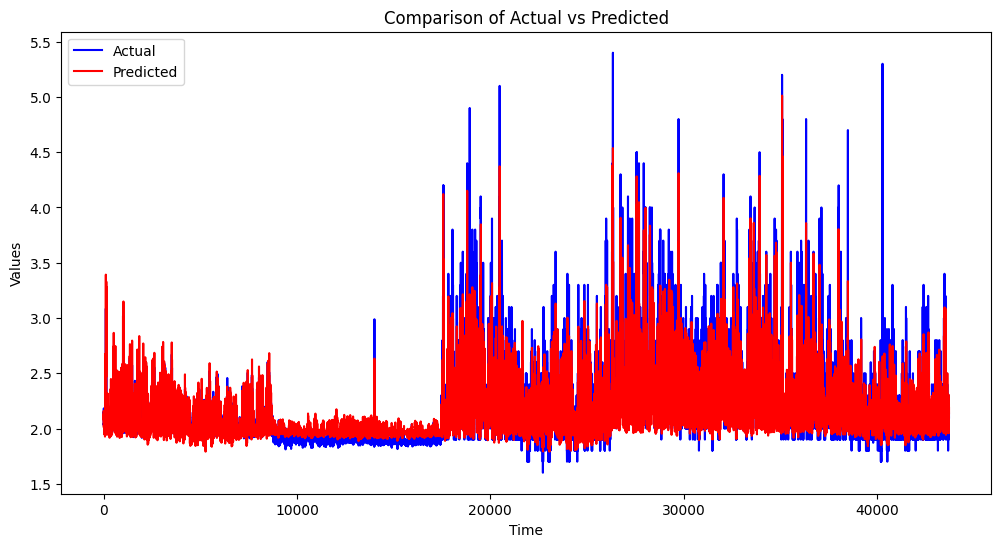

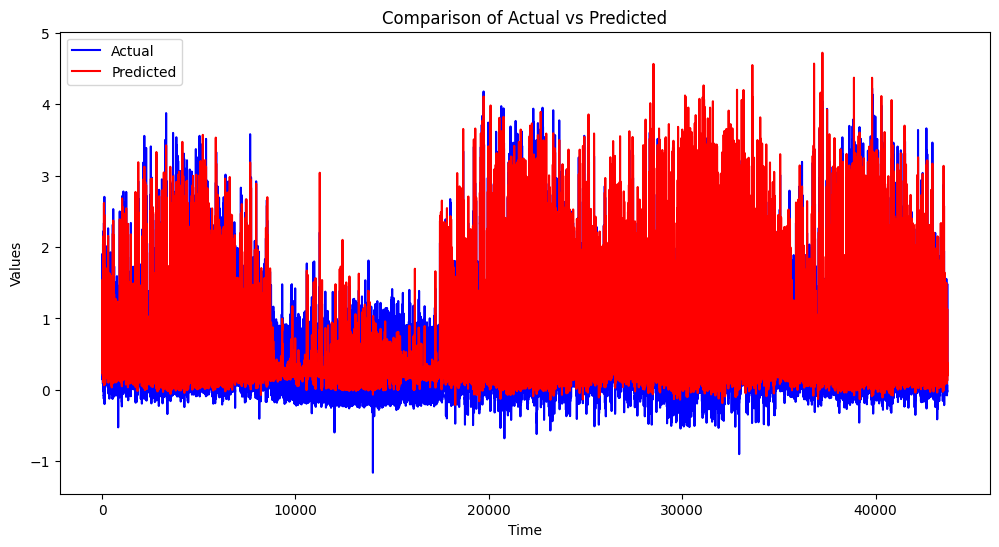

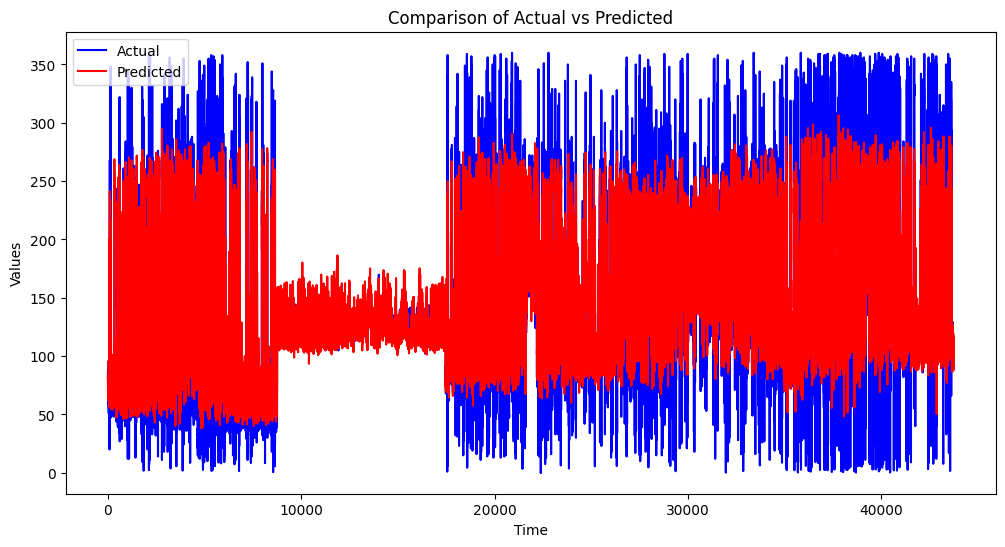

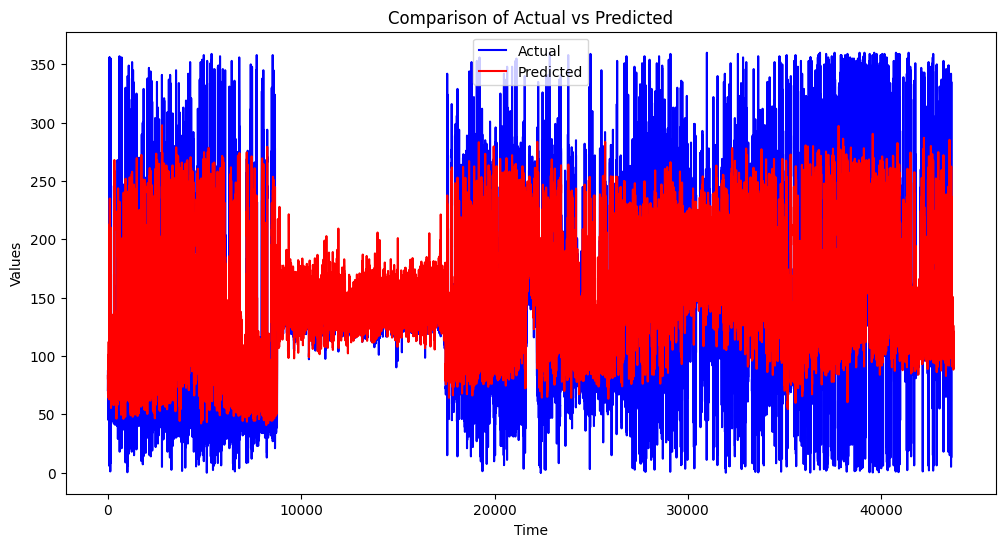

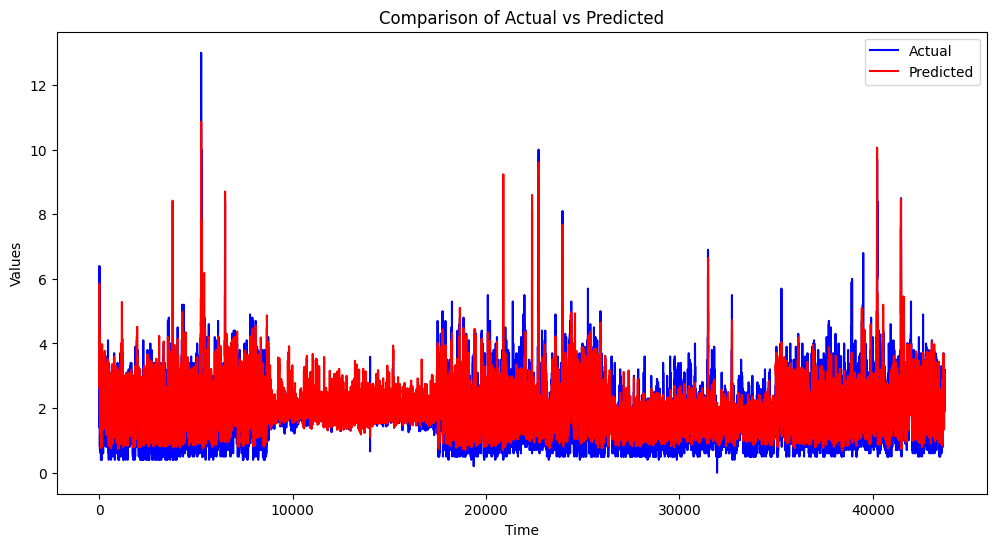

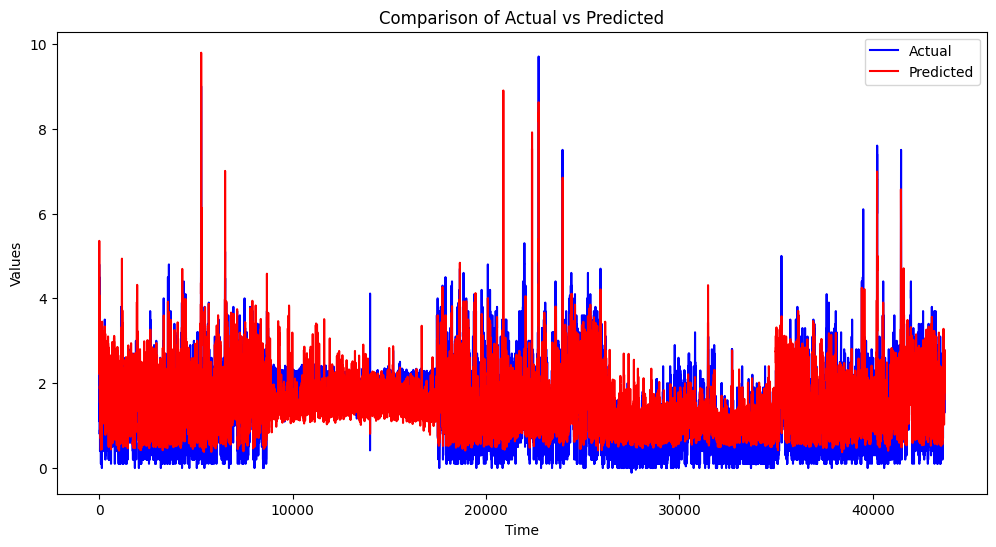

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error


#loss = rfe.evaluate(X_test, y_test)
#print(f'Mean Squared Error on Test Data: {loss}')

# Tính toán sai số trung bình tuyệt đối và sai số bình phương trung bình
# Dự đoán trên tập kiểm tra
#y_pred2 = rfe.predict(testX_rf)

#mae = np.mean(np.abs(y_pred2 - y_test))
#mse = np.mean(np.square(y_pred2 - y_test))

#print("Mean Absolute Error (MAE):", mae)
#print("Mean Squared Error (MSE):", mse)

# Đảo ngược chuẩn hóa cho y_test và y_pred
#for i, column in enumerate(data.columns):
#    y_test[:, i] = scalers[column].inverse_transform(y_test[:, i].reshape(-1, 1)).reshape(-1)
#    y_pred2[:, i] = scalers[column].inverse_transform(y_pred2[:, i].reshape(-1, 1)).reshape(-1)
import matplotlib.pyplot as plt
for i in range(y_test.shape[1]):
  plt.figure(figsize=(12, 6))
  plt.plot(y_test[:, i], color='blue', label='Actual')
  plt.plot(y_pred2[:, i], color='red', label='Predicted')
  plt.title('Comparison of Actual vs Predicted')
  plt.xlabel('Time')
  plt.ylabel('Values')
  plt.legend()
  plt.show()